# RiNNgs dense model 
This notebook is dedicated to design, develop and test solution for online ring counting at NA62-RICH.

The notebook is derived from [hls-tutorial](https://github.com/fastmachinelearning/hls4ml-tutorial).

1. General
    1. Load dependancies
    2. Define global constants
2. Data 
    1. Shuffle dataset
    2. Separate features and targets
3. Model 
    1. Create the model
    2. Configure the model and start training
4. Model in HLS 

5. HLS Synthesis
6. Synthesis

## 1 Definitions and dependancies

In [1]:
import numpy as np
%matplotlib inline
seed = 0
np.random.seed(seed)

import tensorflow as tf
tf.random.set_seed(seed)
print ("TensorFlow version: " + tf.__version__)

import os
os.environ['PATH'] = '/opt/Xilinx/Vivado/2020.1/bin:' + os.environ['PATH']


import plotting


TensorFlow version: 2.3.1


In [ ]:
#from include.helper_fun import * 
#from include.helper_values_rings import *
N_HITS_MAX=64
N_PMT = 2048
maxpmt = 2048
maxhits_evt = 128
maxrings_evt = 8     #the same as in kernel_histogram.cu
r_pmt = 9.0
samples=80000 #samples for each class #we are assuming that there is the same amount of samples for each class 
nLabel=4 #4 features (rings 0 1 2 2+)

## 2 Data processing
We define a function to import data and a class for fitted ring data

In [3]:
class Dataring:
    def __init__(self, x=0.,y=0.,r=0., tothits=0):
        self.x=x
        self.y=y
        self.r=r

A function to parse datafile

In [4]:
def read_data_formatNN(listfiles, all_hits_list, all_features_list, all_datarings, samples):
    #import numpy as np
    debughits=0 #only to debug, it prints the hits for each event
    hits_array=np.zeros(N_HITS_MAX)
    count_events=0
    readringdata=[]
    test_PMT=[]
    for idx, file_ in enumerate(listfiles):
        with open(file_) as loadfile:
            print("Opening %s" % file_)
            for indline,line in enumerate(loadfile):
                if line.split()[0].startswith('0x'):
                    nrings=line.split()[1]
                    nhits=line.split()[3]
                    if int(nhits)>N_HITS_MAX:
                        nhits=N_HITS_MAX
                    for nh in range(int(nhits)):
                        npmt=int(line.split()[4+(3*nh)])
                        hits_array[nh]=npmt
                        if (debughits):
                            test_PMT.append(int(npmt))
                        if nh==int(nhits)-1:
                            all_hits_list.append(hits_array)
                            all_features_list.append(idx) #NOTE: data files must be ordered according to features in filelist
                            hits_array=np.zeros(N_HITS_MAX)
                            if (debughits):
                                test_PMT.sort() #sort degli hit per comodità di confronto
                                print(test_PMT)
                                test_PMT=[]
                    readringdata.append(int(nhits))
                    readringdata.append(int(nrings))
                    storedataring=Dataring()
                    if int(nrings) != 0:
                        for nr in range(int(nrings)):
                            ringline=next(loadfile, '').split()
                            storedataring.x=float(ringline[2])
                            storedataring.y=float(ringline[3])
                            storedataring.r=float(ringline[4])
                            readringdata.append( storedataring )
                            storedataring=Dataring()
                    elif int(nrings)==0:
                        readringdata.append( storedataring )
                    all_datarings.append(readringdata)
                    readringdata=[] #initialize
                    count_events+=1
                    if count_events==samples:
                        count_events=0
                        break

### Fetch the GPURICH 2017 dataset 
If you've just cloned the repo rember to untar -xvf the compressed archive (tar.gz) before

In [5]:
# python arrays to house RICH and rings data
data=[]   # hit list, each element is an event
target=[] # label list, eache element is a prediction for an event
rings=[] # ring data, each elements [ nhits, nrings, Datarings1, Datarings2, ...  ]
print("##RECO_NN FORMAT")     
folder= "data/GPURICH_2017_dataset_1/"
file=['merged_0rings_100000events.log', 'merged_1rings_100000events.log', 'merged_2rings_100000events.log', 'merged_3rings_83498events.log']     
file=[folder+x for x in file]     
read_data_formatNN(file, data, target, rings, samples) 


# check we have read enough data-samples
samples_available=int(len(data)/nLabel)  #how many samples we have available for each class
if samples_available<samples: 
    print("WARNING: samples_available %d instead of the default %d" % (samples_available, samples))
    samples=samples_available

##RECO_NN FORMAT
Opening data/GPURICH_2017_dataset_1/merged_0rings_100000events.log
Opening data/GPURICH_2017_dataset_1/merged_1rings_100000events.log
Opening data/GPURICH_2017_dataset_1/merged_2rings_100000events.log
Opening data/GPURICH_2017_dataset_1/merged_3rings_83498events.log


### Let's print some information about the data set
A global overview on dataset composition 

In [7]:
print("Total labels %d" % nLabel)
print("Total events per label %d" % samples)

print(len(data))
print(len(target))
print(len(rings))

Total labels 4
Total events per label 80000
320000
320000
320000


In [8]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
a = le.fit(target)
b = le.classes_
print(b[:4])


# define an array of literal string for ROC curves used by hls4ml plotting module
labels = np.array(['zero', 'one', 'two', 'three+'])
print(labels)

[0 1 2 3]
['zero' 'one' 'two' 'three+']


Data of a particular event

In [9]:
eventID = 3*80000+4
print("Event[#]: %d" % eventID)
print("Label[#rings]: %d " % target[eventID])
print("HitList:")
print(data[eventID])
print(rings[eventID])

Event[#]: 240004
Label[#rings]: 3 
HitList:
[1536.    0. 1667. 1796. 1546. 1547. 1805. 1808. 1687. 1690. 1563. 1564.
 1833. 1717. 1590. 1720. 1851. 1596. 1728. 1856. 1724. 1733. 1612. 1619.
 1637. 1680. 1636. 1765. 1638. 1896. 1769. 1773. 1777. 1782. 1919.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.]
[35, 3, <__main__.Dataring object at 0x7f68586a0110>, <__main__.Dataring object at 0x7f68586a0210>, <__main__.Dataring object at 0x7f68586a0910>]


### Training and test fractions

In [10]:
# to be checked, uneused?
#train_fraction=0.8
#trainSize=int(samples*train_fraction)
#testSize=int(samples*(1-train_fraction))
#print("For each feature we use %d events as training samples and %d for testing" % (trainSize, testSize))

### Numpy array
We use numpy package for easy data manipulation. 
Note that we keep a copy of the arrays as they were, before any manipulation

In [11]:
#import numpy as np
npEvent=np.array(data) 
npTarget=np.array(target) 
npEvent_sum=np.sum(npEvent,axis=1) 
npEvent_orig=np.copy(npEvent)

### Scaling
Data are normalized. Using N_PMT as scale factor the data range is from 0 to 1 

In [12]:
npEvent=(npEvent/N_PMT)

Data is added with the extra column 'evID' to allow target determination after shuffling

In [13]:
X=np.copy(npEvent)
X=np.insert(X, 0, [val for val in range(samples*nLabel)], axis=1) 

Data is split in two random subsets, train and test

In [14]:
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
X_train_ind, X_valid_ind, y_train, y_valid = train_test_split(X,
                                                              to_categorical(npTarget, nLabel),
                                                              test_size=0.2,
                                                              random_state=0)

#APE     #X_train_ind, X_valid_ind, y_train, y_valid = train_test_split(X,
#HLS4ML  #X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
#SKLEARN #X_train,     X_test, y_train,     y_test = train_test_split(X, y, test_size=0.33, random_state=42)
# the suffix 'ind is to indicate this is the data with the extra evID column

Save the data for future re-use

In [15]:
np.save('X_train_ind.npy', X_train_ind)
np.save('X_valid_ind.npy', X_valid_ind)
np.save('y_train.npy', y_train)
np.save('y_valid.npy', y_valid)
np.save('classes.npy', le.classes_)

The extra column is removed for training

In [16]:
X_train=X_train_ind[:,1:] 
X_valid=X_valid_ind[:,1:]

Wrap data in Dataset objects - Required (not yet enforced) by TensorFlow2

In [17]:
#import tensorflow as tf 
train_data = tf.data.Dataset.from_tensor_slices((X_train, y_train)) 
val_data = tf.data.Dataset.from_tensor_slices((X_valid, y_valid))

The batch size must now be set on the Dataset objects.

In [18]:
batch_size=1024
train_data = train_data.batch(batch_size) 
val_data = val_data.batch(batch_size)

Disable AutoShard 
Note: shard is deterministic. 
The Dataset produced by A.shard(n, i) will contain all elements of A whose index mod n = i

In [19]:
options = tf.data.Options() 
options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF 
train_data = train_data.with_options(options) 
val_data = val_data.with_options(options)

Finally we give a weight to the categories for training.
to "pay more attention" to samples from an under-represented class. 
NOTE: class 1 has low accurancy result, it is not under-represented

In [20]:
class_weight = {0: 1,
                1: 1.25, #weight bigger for the class with less samples
                2: 1,
                3: 1}

# Model in Keras
We use 2 hidden layers with 64, then 16 neurons.
Each layer will use relu activation. 
Add an output layer with 4 neurons (one for each class)
then finish with Softmax activation.

In [21]:
import tensorflow as tf 
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Activation, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l1
from callbacks import all_callbacks # local custom python module by hls4ml team

In [22]:

# Set the input shape
input_shape = (N_HITS_MAX,)
print(f'Feature shape: {input_shape}')

inputs  = tf.keras.Input(shape=input_shape,name = 'input')
h1      = Dense(64, activation='elu',name='fc1')(inputs)
h2      = Dense(16, activation='relu',name='fc2') (h1)
#model.add(BatchNormalization())
outputs = Dense( 4, activation='softmax',name='output')(h2)
model   = Model(inputs=inputs, outputs=outputs)
model.summary()

Feature shape: (64,)
Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 64)]              0         
_________________________________________________________________
fc1 (Dense)                  (None, 64)                4160      
_________________________________________________________________
fc2 (Dense)                  (None, 16)                1040      
_________________________________________________________________
output (Dense)               (None, 4)                 68        
Total params: 5,268
Trainable params: 5,268
Non-trainable params: 0
_________________________________________________________________


## Train the model 
Train the model (try to fuse hls4ml and ape trainings code, with no big success for now)
and save the json and h5 file to skip the training in future use.

In [23]:
TRAIN=True
VERBOSE=True
nepochs= 1000

if TRAIN:
    adam = Adam(lr=0.0001)
    model.compile(optimizer=adam, loss=['categorical_crossentropy'], metrics=['accuracy'])
    
    # instance of the class 'all_callbacks' for custom callback functions (from hls4ml)
    # from tutorial part1 The callbacks will decay the learning rate and save the model into a directory 'model_1' 
    #The model isn't very complex, so this should just take a few minutes even on the CPU. 
    #If you've restarted the notebook kernel after training once, set train = False to load the trained model.

    #folder='model_1'
    # callbacks = all_callbacks(stop_patience = 1000,
   #                           lr_factor = 0.5,
   #                           lr_patience = 10,
   #                           lr_epsilon = 0.000001,
   #                           lr_cooldown = 2,
   #                           lr_minimum = 0.0000001,
   #                           outputDir = folder)

   # my_callbacks = [tf.keras.callbacks.EarlyStopping(patience=2),
   #                 tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
   #                 tf.keras.callbacks.TensorBoard(log_dir='./logs'),
   #                ]

    
    training_history= model.fit(train_data,
                                batch_size=batch_size,
                                epochs=nepochs,
                                verbose=VERBOSE,
                                validation_data=val_data,
                                class_weight=class_weight)

                               
    score = model.evaluate(val_data, verbose=VERBOSE) 
    print("Test score:", score[0]) 
    print("Test accuracy:", score[1]) 
    
else:
    from tensorflow.keras.models import load_model
    model = load_model('weights.h5')
    


Epoch 1/1000
250/250 [==============================] - 1s 3ms/step - loss: 1.1950 - accuracy: 0.5244 - val_loss: 0.9301 - val_accuracy: 0.6980
Epoch 2/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.8892 - accuracy: 0.7182 - val_loss: 0.7590 - val_accuracy: 0.7178
Epoch 3/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.7758 - accuracy: 0.7181 - val_loss: 0.6996 - val_accuracy: 0.7152
Epoch 4/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.7352 - accuracy: 0.7177 - val_loss: 0.6771 - val_accuracy: 0.7154
Epoch 5/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.7179 - accuracy: 0.7181 - val_loss: 0.6653 - val_accuracy: 0.7164
Epoch 6/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.7075 - accuracy: 0.7189 - val_loss: 0.6568 - val_accuracy: 0.7171
Epoch 7/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.6992 - accuracy: 0.7196 - val_loss: 0.6493 - val_accuracy:

250/250 [==============================] - 1s 2ms/step - loss: 0.6053 - accuracy: 0.7475 - val_loss: 0.5632 - val_accuracy: 0.7448
Epoch 58/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.6050 - accuracy: 0.7477 - val_loss: 0.5629 - val_accuracy: 0.7448
Epoch 59/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.6047 - accuracy: 0.7478 - val_loss: 0.5626 - val_accuracy: 0.7450
Epoch 60/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.6044 - accuracy: 0.7480 - val_loss: 0.5624 - val_accuracy: 0.7451
Epoch 61/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.6041 - accuracy: 0.7481 - val_loss: 0.5621 - val_accuracy: 0.7454
Epoch 62/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.6038 - accuracy: 0.7482 - val_loss: 0.5618 - val_accuracy: 0.7455
Epoch 63/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.6035 - accuracy: 0.7483 - val_loss: 0.5615 - val_accuracy: 0.7456

250/250 [==============================] - 1s 2ms/step - loss: 0.5898 - accuracy: 0.7542 - val_loss: 0.5480 - val_accuracy: 0.7503
Epoch 114/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5895 - accuracy: 0.7542 - val_loss: 0.5477 - val_accuracy: 0.7504
Epoch 115/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5893 - accuracy: 0.7544 - val_loss: 0.5475 - val_accuracy: 0.7506
Epoch 116/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5890 - accuracy: 0.7544 - val_loss: 0.5472 - val_accuracy: 0.7507
Epoch 117/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5888 - accuracy: 0.7545 - val_loss: 0.5470 - val_accuracy: 0.7507
Epoch 118/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5885 - accuracy: 0.7546 - val_loss: 0.5467 - val_accuracy: 0.7509
Epoch 119/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5882 - accuracy: 0.7547 - val_loss: 0.5465 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5764 - accuracy: 0.7598 - val_loss: 0.5344 - val_accuracy: 0.7574
Epoch 170/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5762 - accuracy: 0.7599 - val_loss: 0.5341 - val_accuracy: 0.7577
Epoch 171/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5760 - accuracy: 0.7601 - val_loss: 0.5339 - val_accuracy: 0.7578
Epoch 172/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5758 - accuracy: 0.7602 - val_loss: 0.5337 - val_accuracy: 0.7579
Epoch 173/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5756 - accuracy: 0.7602 - val_loss: 0.5335 - val_accuracy: 0.7581
Epoch 174/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5754 - accuracy: 0.7603 - val_loss: 0.5333 - val_accuracy: 0.7581
Epoch 175/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5752 - accuracy: 0.7605 - val_loss: 0.5331 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5672 - accuracy: 0.7632 - val_loss: 0.5252 - val_accuracy: 0.7611
Epoch 226/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5671 - accuracy: 0.7633 - val_loss: 0.5251 - val_accuracy: 0.7612
Epoch 227/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5669 - accuracy: 0.7633 - val_loss: 0.5250 - val_accuracy: 0.7613
Epoch 228/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5668 - accuracy: 0.7633 - val_loss: 0.5249 - val_accuracy: 0.7613
Epoch 229/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5667 - accuracy: 0.7634 - val_loss: 0.5248 - val_accuracy: 0.7613
Epoch 230/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5666 - accuracy: 0.7635 - val_loss: 0.5246 - val_accuracy: 0.7613
Epoch 231/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5664 - accuracy: 0.7636 - val_loss: 0.5245 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5617 - accuracy: 0.7655 - val_loss: 0.5199 - val_accuracy: 0.7634
Epoch 282/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5617 - accuracy: 0.7656 - val_loss: 0.5199 - val_accuracy: 0.7635
Epoch 283/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5616 - accuracy: 0.7656 - val_loss: 0.5198 - val_accuracy: 0.7636
Epoch 284/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5615 - accuracy: 0.7656 - val_loss: 0.5197 - val_accuracy: 0.7636
Epoch 285/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5615 - accuracy: 0.7656 - val_loss: 0.5197 - val_accuracy: 0.7636
Epoch 286/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5614 - accuracy: 0.7656 - val_loss: 0.5196 - val_accuracy: 0.7637
Epoch 287/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5613 - accuracy: 0.7657 - val_loss: 0.5196 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5583 - accuracy: 0.7668 - val_loss: 0.5167 - val_accuracy: 0.7646
Epoch 338/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5583 - accuracy: 0.7669 - val_loss: 0.5167 - val_accuracy: 0.7646
Epoch 339/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5582 - accuracy: 0.7669 - val_loss: 0.5167 - val_accuracy: 0.7646
Epoch 340/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5582 - accuracy: 0.7669 - val_loss: 0.5166 - val_accuracy: 0.7647
Epoch 341/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5581 - accuracy: 0.7669 - val_loss: 0.5166 - val_accuracy: 0.7647
Epoch 342/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5581 - accuracy: 0.7670 - val_loss: 0.5165 - val_accuracy: 0.7648
Epoch 343/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5580 - accuracy: 0.7670 - val_loss: 0.5165 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5559 - accuracy: 0.7680 - val_loss: 0.5146 - val_accuracy: 0.7661
Epoch 394/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5559 - accuracy: 0.7680 - val_loss: 0.5146 - val_accuracy: 0.7660
Epoch 395/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5558 - accuracy: 0.7680 - val_loss: 0.5145 - val_accuracy: 0.7660
Epoch 396/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5558 - accuracy: 0.7680 - val_loss: 0.5145 - val_accuracy: 0.7661
Epoch 397/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5558 - accuracy: 0.7680 - val_loss: 0.5145 - val_accuracy: 0.7661
Epoch 398/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5557 - accuracy: 0.7680 - val_loss: 0.5144 - val_accuracy: 0.7661
Epoch 399/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5557 - accuracy: 0.7680 - val_loss: 0.5144 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5541 - accuracy: 0.7687 - val_loss: 0.5129 - val_accuracy: 0.7668
Epoch 450/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5541 - accuracy: 0.7687 - val_loss: 0.5129 - val_accuracy: 0.7669
Epoch 451/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5540 - accuracy: 0.7686 - val_loss: 0.5129 - val_accuracy: 0.7668
Epoch 452/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5540 - accuracy: 0.7687 - val_loss: 0.5129 - val_accuracy: 0.7669
Epoch 453/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5540 - accuracy: 0.7687 - val_loss: 0.5128 - val_accuracy: 0.7669
Epoch 454/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5539 - accuracy: 0.7687 - val_loss: 0.5128 - val_accuracy: 0.7669
Epoch 455/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5539 - accuracy: 0.7687 - val_loss: 0.5128 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5526 - accuracy: 0.7690 - val_loss: 0.5116 - val_accuracy: 0.7675
Epoch 506/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5526 - accuracy: 0.7690 - val_loss: 0.5116 - val_accuracy: 0.7675
Epoch 507/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5525 - accuracy: 0.7690 - val_loss: 0.5115 - val_accuracy: 0.7675
Epoch 508/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5525 - accuracy: 0.7690 - val_loss: 0.5115 - val_accuracy: 0.7674
Epoch 509/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5525 - accuracy: 0.7691 - val_loss: 0.5115 - val_accuracy: 0.7674
Epoch 510/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5525 - accuracy: 0.7690 - val_loss: 0.5115 - val_accuracy: 0.7674
Epoch 511/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5524 - accuracy: 0.7691 - val_loss: 0.5115 - val_accuracy: 

Epoch 561/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5513 - accuracy: 0.7694 - val_loss: 0.5104 - val_accuracy: 0.7678
Epoch 562/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5513 - accuracy: 0.7694 - val_loss: 0.5104 - val_accuracy: 0.7678
Epoch 563/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5512 - accuracy: 0.7694 - val_loss: 0.5104 - val_accuracy: 0.7678
Epoch 564/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5512 - accuracy: 0.7694 - val_loss: 0.5103 - val_accuracy: 0.7678
Epoch 565/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5512 - accuracy: 0.7694 - val_loss: 0.5103 - val_accuracy: 0.7678
Epoch 566/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5512 - accuracy: 0.7695 - val_loss: 0.5103 - val_accuracy: 0.7680
Epoch 567/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5512 - accuracy: 0.7695 - val_loss: 0.5103 -

250/250 [==============================] - 1s 2ms/step - loss: 0.5501 - accuracy: 0.7699 - val_loss: 0.5094 - val_accuracy: 0.7685
Epoch 618/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5501 - accuracy: 0.7699 - val_loss: 0.5094 - val_accuracy: 0.7685
Epoch 619/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5501 - accuracy: 0.7699 - val_loss: 0.5093 - val_accuracy: 0.7685
Epoch 620/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5501 - accuracy: 0.7699 - val_loss: 0.5093 - val_accuracy: 0.7685
Epoch 621/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5501 - accuracy: 0.7700 - val_loss: 0.5093 - val_accuracy: 0.7685
Epoch 622/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5501 - accuracy: 0.7700 - val_loss: 0.5093 - val_accuracy: 0.7685
Epoch 623/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5500 - accuracy: 0.7700 - val_loss: 0.5093 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5491 - accuracy: 0.7705 - val_loss: 0.5085 - val_accuracy: 0.7686
Epoch 674/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5491 - accuracy: 0.7705 - val_loss: 0.5085 - val_accuracy: 0.7686
Epoch 675/1000
250/250 [==============================] - ETA: 0s - loss: 0.5491 - accuracy: 0.77 - 1s 2ms/step - loss: 0.5491 - accuracy: 0.7704 - val_loss: 0.5085 - val_accuracy: 0.7687
Epoch 676/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5491 - accuracy: 0.7704 - val_loss: 0.5085 - val_accuracy: 0.7687
Epoch 677/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5491 - accuracy: 0.7705 - val_loss: 0.5085 - val_accuracy: 0.7687
Epoch 678/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5491 - accuracy: 0.7705 - val_loss: 0.5084 - val_accuracy: 0.7687
Epoch 679/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5490 - accuracy: 

Epoch 729/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7709 - val_loss: 0.5077 - val_accuracy: 0.7692
Epoch 730/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7710 - val_loss: 0.5077 - val_accuracy: 0.7693
Epoch 731/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7710 - val_loss: 0.5077 - val_accuracy: 0.7693
Epoch 732/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7710 - val_loss: 0.5077 - val_accuracy: 0.7694
Epoch 733/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7710 - val_loss: 0.5077 - val_accuracy: 0.7694
Epoch 734/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7709 - val_loss: 0.5077 - val_accuracy: 0.7695
Epoch 735/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5481 - accuracy: 0.7709 - val_loss: 0.5076 -

250/250 [==============================] - 1s 2ms/step - loss: 0.5474 - accuracy: 0.7712 - val_loss: 0.5070 - val_accuracy: 0.7699
Epoch 786/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5474 - accuracy: 0.7712 - val_loss: 0.5070 - val_accuracy: 0.7700
Epoch 787/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5474 - accuracy: 0.7712 - val_loss: 0.5070 - val_accuracy: 0.7699
Epoch 788/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5474 - accuracy: 0.7712 - val_loss: 0.5070 - val_accuracy: 0.7699
Epoch 789/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5474 - accuracy: 0.7712 - val_loss: 0.5070 - val_accuracy: 0.7700
Epoch 790/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5473 - accuracy: 0.7712 - val_loss: 0.5070 - val_accuracy: 0.7700
Epoch 791/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5473 - accuracy: 0.7712 - val_loss: 0.5069 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5466 - accuracy: 0.7714 - val_loss: 0.5064 - val_accuracy: 0.7705
Epoch 842/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5466 - accuracy: 0.7714 - val_loss: 0.5064 - val_accuracy: 0.7705
Epoch 843/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5466 - accuracy: 0.7715 - val_loss: 0.5063 - val_accuracy: 0.7705
Epoch 844/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5466 - accuracy: 0.7714 - val_loss: 0.5063 - val_accuracy: 0.7705
Epoch 845/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5466 - accuracy: 0.7715 - val_loss: 0.5063 - val_accuracy: 0.7706
Epoch 846/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5466 - accuracy: 0.7715 - val_loss: 0.5063 - val_accuracy: 0.7706
Epoch 847/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5466 - accuracy: 0.7715 - val_loss: 0.5063 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.7717 - val_loss: 0.5058 - val_accuracy: 0.7709
Epoch 898/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.7716 - val_loss: 0.5058 - val_accuracy: 0.7708
Epoch 899/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.7716 - val_loss: 0.5058 - val_accuracy: 0.7707
Epoch 900/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5459 - accuracy: 0.7716 - val_loss: 0.5057 - val_accuracy: 0.7707
Epoch 901/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5458 - accuracy: 0.7716 - val_loss: 0.5057 - val_accuracy: 0.7707
Epoch 902/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5458 - accuracy: 0.7716 - val_loss: 0.5057 - val_accuracy: 0.7707
Epoch 903/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5458 - accuracy: 0.7716 - val_loss: 0.5057 - val_accuracy: 

250/250 [==============================] - 1s 2ms/step - loss: 0.5452 - accuracy: 0.7720 - val_loss: 0.5052 - val_accuracy: 0.7707
Epoch 954/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5452 - accuracy: 0.7720 - val_loss: 0.5052 - val_accuracy: 0.7707
Epoch 955/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5452 - accuracy: 0.7720 - val_loss: 0.5052 - val_accuracy: 0.7708
Epoch 956/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5452 - accuracy: 0.7720 - val_loss: 0.5052 - val_accuracy: 0.7707
Epoch 957/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5452 - accuracy: 0.7720 - val_loss: 0.5052 - val_accuracy: 0.7708
Epoch 958/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5451 - accuracy: 0.7719 - val_loss: 0.5052 - val_accuracy: 0.7709
Epoch 959/1000
250/250 [==============================] - 1s 2ms/step - loss: 0.5451 - accuracy: 0.7719 - val_loss: 0.5051 - val_accuracy: 

In [24]:
print(training_history.history.keys())
import datetime
word_time='_'+str(nepochs)+'ep_'+datetime.datetime.now().strftime("%H.%M.%S.%d%m%Y")
word_time=''

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


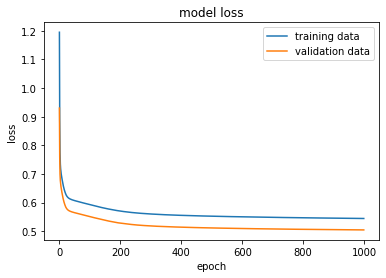

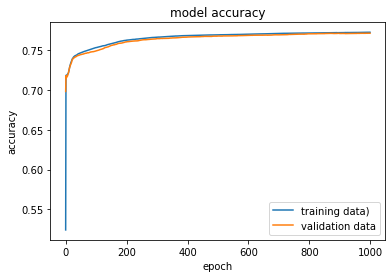

<Figure size 432x288 with 0 Axes>

In [26]:

import matplotlib.pyplot as plt

# Plot history: Loss
plt.plot(training_history.history['loss'], label='training data')
plt.plot(training_history.history['val_loss'], label='validation data')
plt.title('model loss')     
plt.ylabel('loss')     
plt.xlabel('epoch')    
plt.legend(loc="upper right")
plt.savefig('plot_loss'+word_time+'.png', bbox_inches='tight', dpi=200) 
plt.show()


# Plot history: Accuracy
plt.plot(training_history.history['accuracy'], label='training data)')
plt.plot(training_history.history['val_accuracy'], label='validation data')
plt.title('model accuracy')     
plt.ylabel('accuracy')     
plt.xlabel('epoch')  
plt.legend(loc="lower right")
plt.show()
plt.savefig('plot_accuracy'+word_time+'.png', bbox_inches='tight', dpi=200) 

In [27]:
# save JSON and H5    
json="model"+word_time+".json"     
h5="weights"+word_time+".h5" 
model_json = model.to_json()     
with open(json, "w") as json_file:
    json_file.write(model_json)
    model.save_weights(h5)

## Check performance
We completed the training. Now its time to evaluate the performance and proceed with next steps

ROC curve (hls4ml code)
Receiver Operating Characteristics
AUC Area Under Curve
Is a performance measurement for the classification problem at various threshold settings.
ROC is a probability curve
AUC represent the degree or measure of separability
It tells how much the model is capable of distinguishing between classes
The ROC curve is plotted with TPR against the FPR where
True Positive Rate or sensitivity is  Total Positive / (Total Positive + False Negative)
Specificity is Total Negative / (Total Negative + False Positives)
False Positive Rate = 1 - Spevificity

Accuracy: 0.77096875


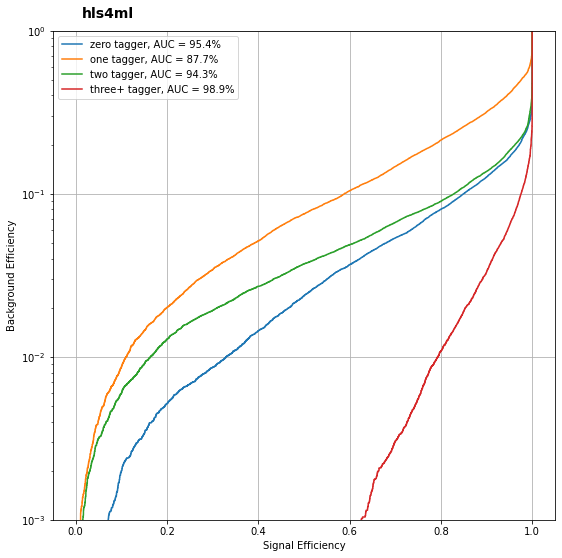

In [28]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
y_keras = model.predict(X_valid)
print("Accuracy: {}".format(accuracy_score(np.argmax(y_valid, axis=1), np.argmax(y_keras, axis=1))))
plt.figure(figsize=(9,9))
_ = plotting.makeRoc(y_valid, y_keras, labels)



# Convert the model
Now we will go through the steps to convert the model we trained to a low-latency optimized FPGA firmware with hls4ml.
First, we will evaluate its classification performance to make sure we haven't lost accuracy using the fixed-point data types.
Then we will synthesize the model with Vivado HLS and check the metrics of latency and FPGA resource usage.
## Make an hls4ml config & model

The hls4ml Neural Network inference library is controlled through a configuration dictionary. In this example we'll use the most simple variation, later exercises will look at more advanced configuration.

In [29]:
import hls4ml
#config = hls4ml.utils.config_from_keras_model(model, granularity='model') # same fxp across the model
config = hls4ml.utils.config_from_keras_model(model, granularity='name') # custom layer datatype



# numerical precision (do affect C-simulation)
config['LayerName']['fc1'   ]['Precision']['weight'] = 'ap_fixed<32,16>'
config['LayerName']['fc1'   ]['Precision']['bias']   = 'ap_fixed<32,16>'
config['LayerName']['fc2'   ]['Precision']['weight'] = 'ap_fixed<32,16>'
config['LayerName']['fc2'   ]['Precision']['bias']   = 'ap_fixed<32,16>'
config['LayerName']['output']['Precision']['weight'] = 'ap_fixed<32,16>'
config['LayerName']['output']['Precision']['bias']   = 'ap_fixed<32,16>'

# implementation parameter (do NOT affect C-simulation)
config['Model']['ReuseFactor'] = 4

# Trace
for layer in config['LayerName'].keys():
    config['LayerName'][layer]['Trace'] = True



print("-----------------------------------")
plotting.print_dict(config)
print("-----------------------------------")

Interpreting Model
Topology:
Layer name: input, layer type: Input
Layer name: fc1, layer type: Dense
  -> Activation (elu), layer name: fc1
Layer name: fc2, layer type: Dense
  -> Activation (relu), layer name: fc2
Layer name: output, layer type: Dense
  -> Activation (softmax), layer name: output
-----------------------------------
Model
  Precision:         ap_fixed<16,6>
  ReuseFactor:       4
  Strategy:          Latency
LayerName
  input
    Precision
      result:        ap_fixed<16,6>
    Trace:           True
  fc1
    Precision
      weight:        ap_fixed<32,16>
      bias:          ap_fixed<32,16>
      result:        ap_fixed<16,6>
    ReuseFactor:     1
    Trace:           True
  fc1_elu
    Precision:       ap_fixed<16,6>
    ReuseFactor:     1
    table_size:      1024
    table_t:         ap_fixed<18,8>
    Trace:           True
  fc2
    Precision
      weight:        ap_fixed<32,16>
      bias:          ap_fixed<32,16>
      result:        ap_fixed<16,6>
    ReuseFa

### Profiling
As you can see, we can choose the precision of everything in our Neural Network.
This is a powerful way to tune the performance, but it's also complicated.
The tools in hls4ml.model.profiling can help you choose the right precision for your model.
(That said, training your model with quantization built in can get around this problem, and that is introduced in Part 4. So, don't go too far down the rabbit hole of tuning your data types without first trying out quantization aware training with QKeras.)

The first thing to try is to numerically profile your model.
This method plots the distribution of the weights (and biases) as a box and whisker plot.
The grey boxes show the values which can be represented with the data types used in the hls_model.
Generally, you need the box to overlap completely with the whisker 'to the right' (large values) otherwise you'll get saturation & wrap-around issues. 
It can be okay for the box not to overlap completely 'to the left' (small values), but finding how small you can go is a matter of trial-and-error.

Providing data, in this case just using the first 1000 examples for speed, will show the same distributions captured at the output of each layer.

Interpreting Model
Topology:
Layer name: input, layer type: InputLayer, current shape: [[None, 64]]
Layer name: fc1, layer type: Dense, current shape: [[None, 64]]
Layer name: fc2, layer type: Dense, current shape: [[None, 64]]
Layer name: output, layer type: Dense, current shape: [[None, 16]]
Creating HLS model
Profiling weights
Profiling activations
   input
   fc1
   fc2
   output


(<Figure size 432x288 with 1 Axes>, <Figure size 432x288 with 1 Axes>)

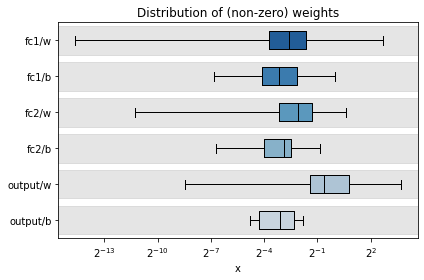

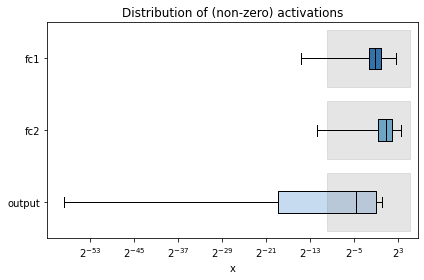

In [30]:
hls_model = hls4ml.converters.convert_from_keras_model(model,
                                                       hls_config=config,
                                                       output_dir='model/hls4ml_prj',
                                                       fpga_part='xcvu9p-flga2104-2L-e',
                                                       project_name='hwFunc',
                                                       clock_period=5,
                                                       io_type='io_parallel')
%matplotlib inline
#hls4ml.model.profiling.numerical(model=model, hls_model=hls_model) # plot only weights
hls4ml.model.profiling.numerical(model=model, hls_model=hls_model, X=X_valid[:1000]) # plot activation 

### Customize
Let's just try setting the precision of the first layer weights to something more narrow than 16 bits. Using fewer bits can save resources in the FPGA. After inspecting the profiling plot above, let's try 8 bits with 1 integer bit.

Then create a new HLSModel, and display the profiling with the new config. This time, just display the weight profile by not providing any data 'X'. Then create the HLSModel and display the architecture. Notice the box around the weights of the first layer reflects the different precision.

Let's visualise what we created. The model architecture is shown, annotated with the shape and data types

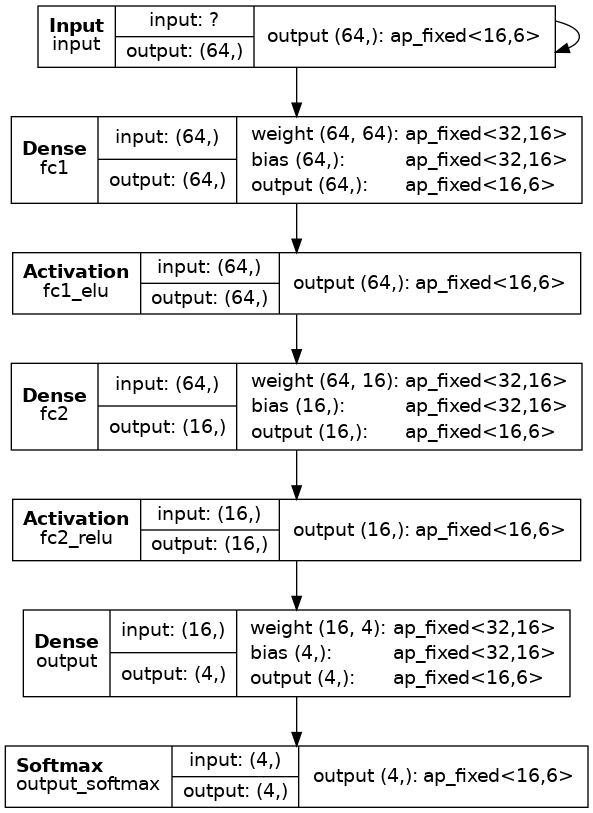

In [31]:
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=None)

### Trace
When we start using customised precision throughout the model, it can be useful to collect the output from each layer to find out when things have gone wrong. 
We enable this trace collection by setting Trace = True for each layer whose output we want to collect.

## Compile, predict (from tutorial Part1)
Now we need to check that this model performance is still good. We compile the hls_model, and then use `hls_model.predict` to execute the FPGA firmware with bit-accurate emulation on the CPU.



## Compile, trace, predict (from tutorial Part2)

Now we need to check that this model performance is still good after reducing the precision. We compile the hls_model, and now use the hls_model.trace method to collect the model output, and also the output for all the layers we enabled tracing for. This returns a dictionary with keys corresponding to the layer names of the model. Stored at that key is the array of values output by that layer, sampled from the provided data. A helper function get_ymodel_keras will return the same dictionary for the Keras model.

We'll just run the trace for the first 1000 examples, since it takes a bit longer and uses more memory than just running predict.


In [32]:
hls_model.compile()

X_valid = np.ascontiguousarray(X_valid) # required!
hls4ml_pred, hls4ml_trace = hls_model.trace(X_valid[:1000])
keras_trace = hls4ml.model.profiling.get_ymodel_keras(model, X_valid[:1000])


y_hls = hls_model.predict(X_valid)



Writing HLS project
Done
Recompiling hwFunc with tracing
Writing HLS project
Done
Processing input in Keras model...
Processing fc1 in Keras model...

If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.

Processing fc2 in Keras model...
Processing output in Keras model...
Done taking outputs for Keras model.


### Inspect
Now we can print out, make plots, or do any other more detailed analysis on the output of each layer to make sure we haven't made the performance worse. And if we have, we can quickly find out where. Let's just print the output of the first layer, for the first sample, for both the Keras and hls4ml models.

In [33]:
layername ='output'
evtID     = 35;

print('Keras layer '+ layername + ' event %d' % evtID)
print(keras_trace[layername][evtID])

print('hls4ml layer '+ layername + ' event %d' % evtID)
print(hls4ml_trace[layername][evtID])

print("difference:")
print(keras_trace[layername][evtID]-hls4ml_trace[layername][evtID])

Keras layer output event 35
tf.Tensor([  2.5395136   1.945806  -15.947425  -17.354261 ], shape=(4,), dtype=float32)
hls4ml layer output event 35
[  2.29199219   2.02539062 -14.93359375 -15.80859375]
difference:
tf.Tensor([ 0.2475214 -0.0795846 -1.0138311 -1.5456676], shape=(4,), dtype=float32)


## Compare
That was easy! Now let's see how the performance compares to Keras:
et's see if we lost performance by using 8 bits for the weights of the first layer by inspecting the accuracy and ROC curve.

Keras  Accuracy: 0.77096875
hls4ml Accuracy: 0.6695


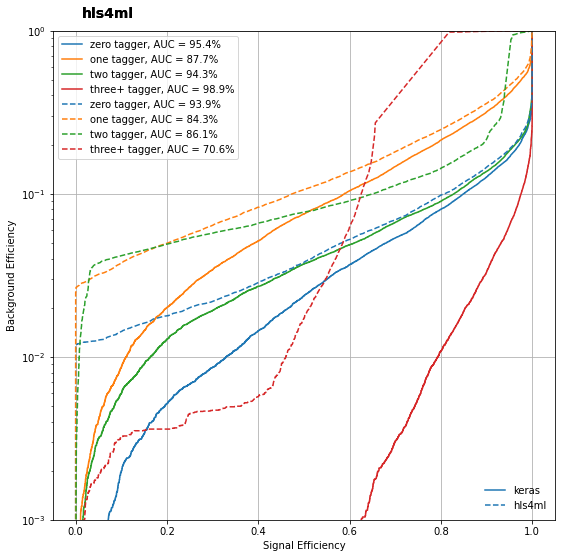

In [34]:
print("Keras  Accuracy: {}".format(accuracy_score(np.argmax(y_valid, axis=1), np.argmax(y_keras, axis=1))))
print("hls4ml Accuracy: {}".format(accuracy_score(np.argmax(y_valid, axis=1), np.argmax(y_hls, axis=1))))

fig, ax = plt.subplots(figsize=(9, 9))
_ = plotting.makeRoc(y_valid, y_keras, labels)
plt.gca().set_prop_cycle(None) # reset the colors
_ = plotting.makeRoc(y_valid, y_hls, labels, linestyle='--')

from matplotlib.lines import Line2D
lines = [Line2D([0], [0], ls='-'),
         Line2D([0], [0], ls='--')]
from matplotlib.legend import Legend
leg = Legend(ax, lines, labels=['keras', 'hls4ml'],
            loc='lower right', frameon=False)
ax.add_artist(leg)

## Synthesize
Now we'll actually use Vivado HLS to synthesize the model. We can run the build using a method of our `hls_model` object.
After running this step, we can integrate the generated IP into a workflow to compile for a specific FPGA board.
In this case, we'll just review the reports that Vivado HLS generates, checking the latency and resource usage.

**This can take several minutes.**

While the C-Synthesis is running, we can monitor the progress looking at the log file by opening a terminal from the notebook home, and executing:

`tail -f model_1/hls4ml_prj/vivado_hls.log`

In [35]:
hls_model.build(csim=False)

{'EstimatedClockPeriod': '4.335',
 'BestLatency': '10',
 'WorstLatency': '10',
 'IntervalMin': '1',
 'IntervalMax': '1',
 'BRAM_18K': '35',
 'DSP48E': '5145',
 'FF': '20373',
 'LUT': '134862',
 'URAM': '0',
 'AvailableBRAM_18K': '4320',
 'AvailableDSP48E': '6840',
 'AvailableFF': '2364480',
 'AvailableLUT': '1182240',
 'AvailableURAM': '960'}

## Check the reports
Print out the reports generated by Vivado HLS. Pay attention to the Latency and the 'Utilization Estimates' sections

In [ ]:
hls4ml.report.read_vivado_report('model_1/hls4ml_prj/')